In [1]:
import tmap as tm
import torch
import time
import numpy as np
from numpy.random import RandomState
import re

import graphistry

import os
from dotenv import load_dotenv
load_dotenv()  # take environment variables from .env.

from pyvis import network as net
import networkx as nx
from sklearn import manifold
from sklearn.decomposition import PCA

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
plt.rcParams['figure.figsize'] = [20, 20]

In [2]:
graphistry.register(api=3, protocol="https", server="hub.graphistry.com", username=os.environ['GRAPHISTRY_USERNAME'], password=os.environ['GRAPHISTRY_PASSWORD'])

In [3]:
import wandb
from transformers import GPT2Tokenizer
from soft_prompt_tuning.soft_prompt_opt import ParaphraseOPT

# Init embedding space

In [12]:
wandb.init(project="test-popt-dump", entity="clyde013", name="test-model", allow_val_change=True)
wandb.config.update({"embedding_n_tokens": 111}, allow_val_change=True)

#checkpoint = r"training_checkpoints/30-05-2022-1.3b/soft-opt-epoch=179-val_loss=1.397.ckpt"
checkpoint_111 = r"training_checkpoints/optimize/soft-opt-epoch=029-val_loss=0.487-optimizer_type=Adam-embedding_n_tokens=111.ckpt"
checkpoint_59 = r"training_checkpoints/optimize/soft-opt-epoch=029-val_loss=0.793-optimizer_type=Adam-embedding_n_tokens=59.ckpt"
model_name = "facebook/opt-1.3b"

torch.cuda.empty_cache()

AVAIL_GPUS = min(1, torch.cuda.device_count())

model = ParaphraseOPT.load_from_custom_save(model_name, checkpoint_111)
model = model.eval()
learned_embeddings_111 = model.model.soft_embedding.learned_embedding.detach()

wandb.config.update({"embedding_n_tokens": 59}, allow_val_change=True)
model = ParaphraseOPT.load_from_custom_save(model_name, checkpoint_59)
model = model.eval()
learned_embeddings_59 = model.model.soft_embedding.learned_embedding.detach()

# default_model = ParaphraseOPT(model_name)

tokenizer = GPT2Tokenizer.from_pretrained(model_name)

original_embeddings = model.model.soft_embedding.wte.weight.detach()

# TSNE

In [24]:
def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    
def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(10, 10), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()

Determine based on [vocab_size, hidden_size] from opt1.3b config.json https://huggingface.co/facebook/opt-1.3b/blob/main/config.json

Fitting PCA
Fitting TSNE
Generating the plot took 133190.83786010742ms.


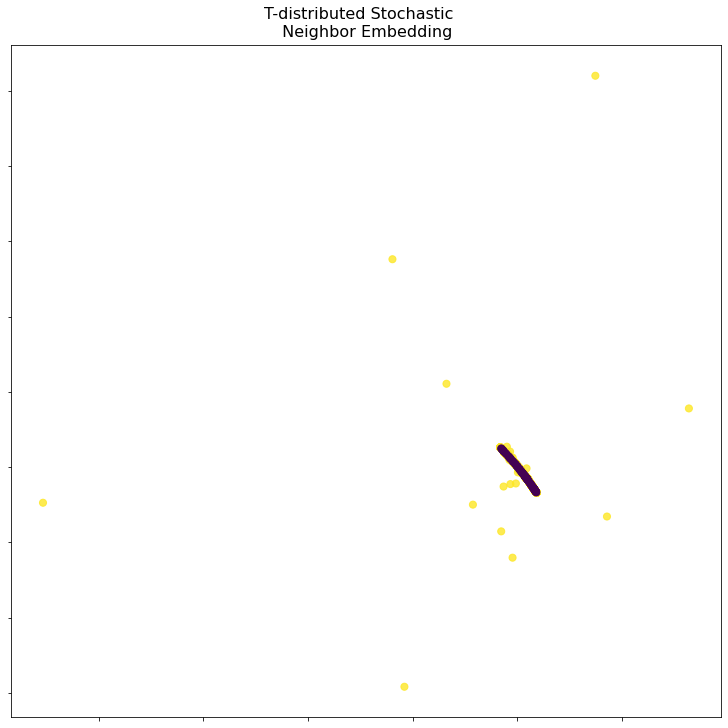

In [27]:
start = time.time()
n_components = 2
rng = RandomState(0)

print("Fitting PCA")
pca = PCA(n_components=50)
pca.fit(np_arr)
X = pca.transform(np_arr)

print("Fitting TSNE")
t_sne = manifold.TSNE(
    n_components=n_components,
    learning_rate="auto",
    perplexity=30,
    n_iter=250,
    init="random",
    random_state=rng,
)
fitted_t_sne = t_sne.fit_transform(X)

print(f"Generating the plot took {(time.time() - start) * 1000}ms.")
plot_2d(fitted_t_sne, c_labels, "T-distributed Stochastic  \n Neighbor Embedding")

# TMAP

The inconsistencies in the relative positions of the embedding points could be attributed to phase 4 in the tmap algorithm described [here](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-0416-x#Sec2). They conduct kruskal's to get a constructed MST tree, reducing computation times by large margins, before using a spring based graph layout alogrithm (probably the Fruchterman-Reingold force-directed algorithm) to plot out the points. But the tradeoff is that if points are not connected on the MST then their relative distances are not accounted for when placing points on the graph, only the neighbours. While this *might* yield multiple locally optimal solutions, it is possible that relative distances between global clusters of points are not accounted for, resulting in vastly different positionings of embedding points. While their neighbours might always be close together no matter the random initialisation, their global position might vary, as there is no way to solve for a deterministic solution without the connections of a fully connected graph (which is too expensive to compute).

In [4]:
enc = tm.Minhash(d=50, seed=42, sample_size=130)

mh_a = enc.from_weight_array(tm.VectorFloat([1, 1, 1, 1, 0, 1, 0, 1, 1, 0]))
mh_b = enc.from_weight_array(tm.VectorFloat([1, 0, 1, 1, 0, 1, 1, 0, 1, 0]))
mh_c = enc.from_weight_array(tm.VectorFloat([1, 0, 1, 1, 1, 1, 1, 0, 1, 0]))

dist_a_b = enc.get_distance(mh_a, mh_b)
dist_b_c = enc.get_distance(mh_b, mh_c)
dist_a_c = enc.get_distance(mh_a, mh_c)

print(dist_a_b)
print(dist_b_c)
print(dist_a_c)

0.26153844594955444
0.11153846979141235
0.32692307233810425


In [5]:
enc.batch_from_weight_array([tm.VectorFloat([1, 1, 1, 1, 0, 1, 0, 1, 1, 0]),tm.VectorFloat([1, 0, 1, 1, 0, 1, 1, 0, 1, 0])])

[VectorUint[5, 1, 7, 1, 7, 1, 2, 0, 8, 0, 8, 1, 3, 0, 3, 1, 0, 1, 8, 1, 5, 0, 7, 0, 3, 1, 5, 1, 1, 1, 0, 1, 3, 1, 0, 0, 0, 1, 7, 1, 0, 1, 3, 1, 0, 1, 8, 1, 2, 0, 1, 1, 0, 1, 2, 0, 2, 1, 7, 1, 2, 1, 0, 0, 3, 1, 0, 1, 0, 1, 2, 0, 8, 1, 0, 1, 3, 1, 2, 2, 5, 1, 2, 0, 3, 1, 3, 0, 3, 1, 0, 1, 3, 1, 7, 0, 5, 1, 0, 1, 5, 1, 0, 1, 0, 1, 2, 0, 3, 0, 0, 1, 8, 1, 7, 0, 5, 1, 1, 1, 7, 0, 7, 0, 5, 1, 7, 1, 2, 1, 7, 0, 2, 1, 5, 1, 1, 1, 3, 0, 1, 0, 5, 0, 0, 1, 5, 1, 3, 2, 8, 1, 7, 0, 2, 2, 0, 0, 3, 0, 0, 1, 7, 0, 7, 1, 1, 0, 1, 0, 2, 1, 0, 1, 8, 0, 2, 1, 3, 0, 3, 1, 2, 1, 0, 0, 2, 1, 3, 1, 8, 0, 5, 0, 1, 1, 0, 0, 1, 0, 1, 1, 8, 1, 7, 1, 8, 1, 0, 1, 5, 1, 1, 1, 5, 1, 8, 1, 5, 0, 1, 0, 8, 1, 1, 1, 8, 1, 1, 1, 7, 1, 1, 1, 8, 0, 2, 1, 8, 1, 0, 1, 2, 1, 8, 0, 5, 1, 0, 0, 3, 0, 0, 1, 1, 1, 8, 0, 5, 1],
 VectorUint[5, 1, 5, 1, 0, 1, 2, 0, 8, 0, 8, 1, 3, 0, 3, 1, 6, 0, 6, 1, 5, 0, 6, 0, 3, 1, 5, 1, 8, 1, 0, 1, 3, 1, 6, 1, 0, 1, 6, 1, 0, 1, 3, 1, 0, 1, 8, 1, 2, 0, 6, 1, 0, 1, 2, 0, 2, 1, 5, 3, 2, 1, 0, 0, 3, 

In [10]:
enc = tm.Minhash(d=50, seed=42, sample_size=130)
mh_a, mh_b = enc.batch_from_weight_array([tm.VectorFloat([1, 1, 1, 1, 0, 1, 0, 1, 1, 0]),tm.VectorFloat([1, 0, 1, 1, 0, 1, 1, 0, 1, 0])])
mh_c = enc.from_weight_array(tm.VectorFloat([1, 0, 1, 1, 1, 1, 1, 0, 1, 0]))
print(enc.get_distance(mh_a, mh_b))
print(enc.get_distance(mh_b, mh_c))

0.26153844594955444
0.11153846979141235


In [6]:
# Use 128 permutations to create the MinHash
np.random.seed(42)
enc = tm.Minhash(128, seed=42)

d = 10
n = 100

data = []

# Generating some random data
start = time.time()
for _ in range(n):
    data.append(tm.VectorFloat(np.random.randint(0, high=10, size=d)))
print(f"Generating the data took {(time.time() - start) * 1000}ms.")
data[0:3]

Generating the data took 4.508018493652344ms.


[VectorFloat[6, 3, 7, 4, 6, 9, 2, 6, 7, 4],
 VectorFloat[3, 7, 7, 2, 5, 4, 1, 7, 5, 1],
 VectorFloat[4, 0, 9, 5, 8, 0, 9, 2, 6, 3]]

In [7]:
lf = tm.LSHForest(128)
# Use batch_add to parallelize the insertion of the arrays
start = time.time()
lf.batch_add(enc.batch_from_weight_array(data))
print(f"Adding the data took {(time.time() - start) * 1000}ms.")

# Index the added data
start = time.time()
lf.index()
print(f"Indexing took {(time.time() - start) * 1000}ms.")

# Construct the k-nearest neighbour graph
start = time.time()
knng_from = tm.VectorUint()
knng_to = tm.VectorUint()
knng_weight = tm.VectorFloat()
_ = lf.get_knn_graph(knng_from, knng_to, knng_weight, 10)

print(f"The layout generation took {(time.time() - start) * 1000}ms.")

Adding the data took 18.000125885009766ms.
Indexing took 0.0ms.
The layout generation took 33.99968147277832ms.


### Test times for different distance methods

In [9]:
query_hash = enc.from_weight_array(tm.VectorFloat(np.random.randint(0, high=10, size=d)))
query_hash

VectorUint[8, 4, 8, 8, 7, 4, 8, 4, 7, 3, 8, 13, 8, 4, 5, 2, 8, 5, 8, 1, 8, 2, 8, 3, 8, 10, 8, 20, 7, 1, 1, 0, 1, 2, 5, 2, 7, 2, 8, 8, 7, 3, 8, 13, 8, 3, 1, 3, 5, 3, 8, 2, 8, 6, 8, 3, 7, 3, 5, 2, 1, 2, 8, 5, 8, 5, 8, 8, 8, 3, 8, 3, 8, 9, 8, 3, 7, 3, 8, 3, 8, 3, 8, 2, 8, 5, 1, 2, 8, 4, 8, 4, 1, 1, 8, 3, 7, 3, 5, 5, 8, 5, 5, 1, 8, 7, 8, 3, 8, 42, 7, 2, 7, 9, 8, 1, 8, 4, 8, 2, 8, 6, 8, 5, 8, 9, 1, 1, 8, 2, 8, 37, 8, 4, 1, 3, 8, 15, 7, 2, 7, 4, 8, 7, 8, 10, 8, 27, 7, 3, 8, 3, 8, 9, 8, 13, 8, 6, 7, 2, 8, 47, 8, 2, 8, 18, 8, 3, 1, 4, 8, 18, 8, 4, 8, 2, 8, 9, 8, 5, 1, 2, 1, 4, 8, 3, 5, 2, 8, 10, 8, 5, 1, 2, 8, 9, 8, 3, 8, 4, 1, 2, 5, 2, 1, 2, 8, 3, 8, 6, 8, 22, 8, 3, 8, 9, 8, 9, 8, 3, 8, 1, 8, 3, 8, 22, 8, 3, 8, 3, 7, 3, 1, 2, 8, 21, 8, 11, 7, 2, 8, 1, 8, 4, 8, 6, 5, 1, 8, 3, 1, 1, 8, 4, 8, 4]

In [10]:
start = time.time()

print(lf.query(query_hash, 10))

print(f"Time taken: {(time.time() - start) * 1000}ms")

VectorUint[8, 15, 20, 37, 49, 53, 55, 66, 84, 96]
Time taken: 1.255035400390625ms


query and query_linear_scan give different results? query_linear scan first result is the same as `lf.get_distance`

In [11]:
start = time.time()

for i in range(100):
    lf.query_linear_scan(query_hash, 10)

print(f"Time taken: {(time.time() - start) * 1000}ms")

Time taken: 32.05704689025879ms


Lazy to compare batch adding to the lshforest and then querying.

In [114]:
lf.get_hash(0), lf.get_hash(1)

(VectorUint[5, 2, 5, 4, 5, 9, 5, 12, 5, 10, 5, 7, 8, 3, 5, 2, 5, 15, 8, 1, 5, 7, 5, 1, 5, 4, 5, 13, 7, 1, 9, 1, 5, 19, 5, 2, 5, 7, 5, 7, 5, 3, 4, 2, 8, 3, 5, 10, 2, 1, 8, 2, 0, 1, 5, 4, 5, 5, 5, 3, 5, 10, 5, 10, 5, 7, 5, 5, 4, 1, 5, 18, 5, 3, 5, 4, 5, 11, 2, 2, 2, 1, 8, 2, 8, 4, 5, 7, 7, 1, 0, 3, 5, 3, 5, 2, 5, 5, 5, 6, 5, 11, 5, 1, 8, 5, 5, 6, 5, 12, 2, 2, 5, 7, 5, 5, 5, 12, 8, 2, 5, 6, 5, 6, 5, 10, 5, 4, 5, 6, 4, 2, 5, 10, 5, 7, 4, 1, 5, 12, 2, 6, 2, 2, 8, 8, 0, 2, 5, 4, 2, 2, 2, 2, 5, 8, 5, 3, 7, 2, 5, 4, 5, 3, 7, 2, 5, 8, 5, 9, 5, 14, 5, 5, 8, 2, 5, 5, 5, 6, 5, 6, 5, 5, 5, 14, 5, 2, 5, 20, 8, 4, 5, 4, 7, 3, 5, 20, 5, 23, 5, 12, 2, 8, 5, 3, 5, 10, 5, 6, 5, 15, 5, 9, 5, 19, 2, 3, 8, 3, 8, 1, 8, 3, 5, 5, 8, 2, 8, 3, 5, 17, 5, 5, 2, 3, 5, 3, 5, 11, 8, 1, 5, 7, 5, 36, 5, 1, 5, 1, 0, 2, 5, 3, 8, 3],
 VectorUint[8, 2, 7, 3, 7, 4, 7, 2, 7, 3, 7, 5, 2, 2, 2, 2, 7, 4, 1, 3, 2, 8, 2, 3, 1, 13, 2, 3, 7, 1, 1, 0, 1, 2, 1, 5, 7, 2, 7, 2, 7, 3, 2, 9, 1, 1, 1, 3, 2, 1, 1, 4, 1, 4, 7, 5, 7, 3, 7, 2

In [115]:
lf.get_distance_by_id(0, 1)

0.8515625

In [116]:
knng_weight, knng_from, knng_to

(VectorFloat[-1, 0.28125, 0.296875, 0.429688, 0.445312, 0.460938, 0.46875, 0.515625, 0.523438, 0.53125, -1, 0.492188, 0.515625, 0.53125, 0.609375, 0.617188, 0.617188, 0.640625, 0.648438, 0.65625, -1, 0.195312, 0.375, 0.421875, 0.429688, 0.453125, 0.5, 0.507812, 0.515625, 0.53125, -1, 0.296875, 0.421875, 0.453125, 0.476562, 0.523438, 0.53125, 0.5625, 0.585938, 0.609375, -1, 0.304688, 0.390625, 0.492188, 0.507812, 0.507812, 0.515625, 0.523438, 0.53125, 0.539062, -1, 0.445312, 0.492188, 0.523438, 0.554688, 0.554688, 0.554688, 0.585938, 0.59375, 0.601562, -1, 0.03125, 0.203125, 0.304688, 0.375, 0.5, 0.53125, 0.53125, 0.539062, 0.546875, -1, 0.21875, 0.359375, 0.429688, 0.492188, 0.53125, 0.53125, 0.539062, 0.546875, 0.546875, -1, 0.226562, 0.460938, 0.539062, 0.585938, 0.617188, 0.632812, 0.648438, 0.648438, 0.65625, -1, 0.304688, 0.304688, 0.335938, 0.46875, 0.484375, 0.5, 0.507812, 0.53125, 0.53125, -1, 0.492188, 0.53125, 0.59375, 0.59375, 0.601562, 0.609375, 0.617188, 0.648438, 0.648438

In [13]:
edges = [i for i in zip(knng_from, knng_to, knng_weight) if i[0] != i[1]]
# 0, 0 is self connection, remove.
edges[0:20]

[(0, 45, 0.28125),
 (0, 87, 0.296875),
 (0, 71, 0.4296875),
 (0, 51, 0.4453125),
 (0, 22, 0.4609375),
 (0, 13, 0.46875),
 (0, 56, 0.515625),
 (0, 42, 0.5234375),
 (0, 82, 0.53125),
 (1, 10, 0.4921875),
 (1, 81, 0.515625),
 (1, 27, 0.53125),
 (1, 40, 0.609375),
 (1, 23, 0.6171875),
 (1, 24, 0.6171875),
 (1, 34, 0.640625),
 (1, 18, 0.6484375),
 (1, 19, 0.65625),
 (2, 86, 0.1953125),
 (2, 16, 0.375)]

Have to create both an MST and the complete graph. We have 2 options:
1. using the weights of the complete graph to generate a layout and then only plotting the MST's edge connections (very computationally expensive)
1. following the original paper implementation of using MST for both layout generation and plotting edge connections.

When using `spring_connection` we have to invert the edge weights as the edge weights become spring attractive coefficients, whereas in other layouts such as `kamada_kawai` edge weights are used as cost functions.

In [14]:
edges.sort(key=lambda x:x[2])
edges[0:20]

[(6, 32, 0.03125),
 (32, 6, 0.03125),
 (16, 74, 0.078125),
 (74, 16, 0.078125),
 (62, 69, 0.0859375),
 (69, 62, 0.0859375),
 (18, 40, 0.1171875),
 (40, 18, 0.1171875),
 (45, 87, 0.1484375),
 (87, 45, 0.1484375),
 (52, 66, 0.1796875),
 (66, 52, 0.1796875),
 (2, 86, 0.1953125),
 (86, 2, 0.1953125),
 (6, 31, 0.203125),
 (13, 56, 0.203125),
 (31, 6, 0.203125),
 (56, 13, 0.203125),
 (7, 99, 0.21875),
 (99, 7, 0.21875)]

In [68]:
def find_par(i):
    if par[i] == i:
        return i
    par[i] = find_par(par[i])
    return par[i]

In [67]:
def join(x, y):
    x = find_par(x)
    y = find_par(y)
    if x == y:
        return
    if rnk[x] < rnk[y]:
        par[x] = y
    else:
        par[y] = x
    if rnk[x] == rnk[y]:
        rnk[x] += 1

In [159]:
par = [i for i in range(0, n+1)]
rnk = [0 for i in range(0, n+1)]

g_mst = nx.Graph()
for edge in edges:
    x = edge[0]
    y = edge[1]
    
    if find_par(x) != find_par(y):
        # append edge to the mst
        g_mst.add_edge(edge[0], edge[1], weight=(1-edge[2]))
        g_mst.nodes[edge[0]]["title"] = f"{edge[0]}"
        join(x, y)
        
g_mst.edges.data("weight")

EdgeDataView([(6, 32, 0.96875), (6, 31, 0.796875), (6, 9, 0.6953125), (32, 38, 0.65625), (16, 74, 0.921875), (16, 64, 0.6484375), (74, 86, 0.71875), (74, 58, 0.65625), (74, 54, 0.53125), (62, 69, 0.9140625), (62, 67, 0.7578125), (62, 95, 0.6015625), (18, 40, 0.8828125), (18, 79, 0.5), (40, 88, 0.5703125), (45, 87, 0.8515625), (45, 0, 0.71875), (45, 71, 0.640625), (45, 42, 0.6015625), (45, 28, 0.40625), (87, 13, 0.703125), (87, 51, 0.578125), (52, 66, 0.8203125), (52, 22, 0.5), (66, 15, 0.5390625), (66, 5, 0.5078125), (2, 86, 0.8046875), (2, 65, 0.390625), (86, 61, 0.65625), (13, 56, 0.796875), (56, 99, 0.671875), (7, 99, 0.78125), (99, 46, 0.625), (8, 84, 0.7734375), (8, 57, 0.4609375), (84, 34, 0.625), (84, 30, 0.4609375), (11, 98, 0.765625), (11, 64, 0.6796875), (67, 73, 0.6875), (49, 55, 0.75), (49, 23, 0.4921875), (55, 20, 0.4609375), (46, 61, 0.7421875), (46, 76, 0.609375), (61, 43, 0.6015625), (60, 64, 0.7265625), (64, 41, 0.6953125), (3, 93, 0.703125), (3, 58, 0.578125), (3, 83,

In [160]:
g = nx.Graph()
g.add_weighted_edges_from([(i[0], i[1], 1-i[2]) for i in edges])
#g.add_weighted_edges_from(edges)

# Custom class

Create a custom class to deal with visualisations. Should be able to initialise from a model's fixed embeddings. Then in the init function construct a minhash encoder and lsh forest (with a seed), and then using the lsh forest create an initial MST use the networkx layouts to find the x, y positions, then use those as anchor points. Should then be able to take in inputs of learned embeddings with another function, and then using `query linear scan` find the closest neighbours of all the passed in learned embeddings, from there add the points to the MST, either without trying to form another MST (just leave knn connections) or find a locally optimal MST solution. Output graphs should ideally be pyvis networks as they allow for interactive visualisations.

In [5]:
class vis():    
    def __init__(self, fixed_embeddings, dims:int=512, load_path:str=None, save_path:str=r"visualisations/vis_lf_fixed.dat", seed:int=69, verbose:bool=True):
        if verbose: print("seeding...")
        self.seed = seed
        np.random.seed(self.seed)
        
        self.fixed_embeddings = fixed_embeddings
        self.enc = tm.Minhash(self.fixed_embeddings.size(dim=1), seed=self.seed, sample_size=dims)
        self.lf = tm.LSHForest(dims * 2, 128)
        
        # init the LSHForest
        if load_path is None:
            tmp = []
            if verbose: print("batch add and indexing...")
            for i in fixed_embeddings:
                tmp.append(tm.VectorFloat(i.tolist()))
            self.lf.batch_add(self.enc.batch_from_weight_array(tmp))
            self.lf.index()
            self.lf.store(save_path)
        else:
            if verbose: print(f"loading from {load_path}...")
            self.lf.restore(load_path)
            
        # Construct the k-nearest neighbour graph
        if verbose: print("Getting KNN graph...")
        knng_from = tm.VectorUint()
        knng_to = tm.VectorUint()
        knng_weight = tm.VectorFloat()
        _ = self.lf.get_knn_graph(knng_from, knng_to, knng_weight, 10)        

        # find the MST of the knn graph
        if verbose: print("Finding MST...")
        self.g_mst = self.create_mst([i for i in zip(knng_from, knng_to, knng_weight) if i[0] != i[1]])

        # find x, y positions of the fixed embeddings layout
        if verbose: print("Generating layout...")
        self.pos = nx.nx_agraph.graphviz_layout(self.g_mst, prog="sfdp")
        self.fixed = list(self.pos.keys())
    
    def graph_learned_embeddings(self, learned_embeddings):
        # create deepcopy of g_mst
        g = nx.Graph(self.g_mst)
        # index to begin from (since indexes are 0 indexed we start from len)
        index = len(self.g_mst)
        for i in learned_embeddings:
            query_hash = self.enc.from_weight_array(tm.VectorFloat(i.tolist()))
            # query_linear_scan returns list of tuples(weight, neighbour). invert the weights because spring layout.
            scan = self.lf.query_linear_scan(query_hash, 1)[0]
            g.add_edge(index, scan[1], weight=1-scan[0])
            index += 1
        
        return g
            
    # kruskals algorithm for finding MST
    def create_mst(self, edgelist):
        self.par = [i for i in range(0, self.fixed_embeddings.size(dim=0)+1)]
        self.rnk = [0 for i in range(0, self.fixed_embeddings.size(dim=0)+1)]
        edges = sorted(edgelist, key=lambda x:x[2])
        g_mst = nx.Graph()

        for edge in edges:
            x = edge[0]
            y = edge[1]

            if self._find_par(x) != self._find_par(y):
                # append edge to the mst. invert the weights because spring layout.
                g_mst.add_edge(edge[0], edge[1], weight=edge[2])
                g_mst.nodes[edge[0]]["title"] = f"{edge[0]}"
                self._join(x, y)

        return g_mst
    
    def _find_par(self, i):
        if self.par[i] == i:
            return i
        self.par[i] = self._find_par(self.par[i])
        return self.par[i]

    def _join(self, x, y):
        x = self._find_par(x)
        y = self._find_par(y)
        if x == y:
            return
        if self.rnk[x] < self.rnk[y]:
            self.par[x] = y
        else:
            self.par[y] = x
        if self.rnk[x] == self.rnk[y]:
            self.rnk[x] += 1

In [6]:
visualisation = vis(original_embeddings, load_path=r"visualisations/vis_lf_fixed.dat")

seeding...
loading from visualisations/vis_lf_fixed.dat...
Getting KNN graph...
Finding MST...
Generating layout...


C:\Users\weipy\anaconda3\envs\OPT\lib\site-packages\pygraphviz\agraph.py:1402: RuntimeWarning: Error: remove_overlap: Graphviz not built with triangulation library

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


In [23]:
g = visualisation.graph_learned_embeddings(learned_embeddings_111)
pos = nx.spring_layout(g, fixed=visualisation.g_mst.nodes, pos=visualisation.pos, k=0.0015)
len(g.nodes), len(visualisation.g_mst.nodes)

(50383, 50272)

In [24]:
mapping = {v: re.sub(r'(\\xc4|\\xa0)|[\'\"\\]', '', repr(k.encode("utf-8"))[2:-1]) for k, v in tokenizer.get_vocab().items()}

for n, p in pos.items():
    g.nodes[n]['x'] = float(p[0])
    g.nodes[n]['y'] = float(p[1])
    # there are some unreachable tokens as the tokenizer's vocab size does not match that of the config
    g.nodes[n]['title'] = mapping[n] if n < len(tokenizer) else f"learned embedding {n-len(visualisation.g_mst.nodes)}"
    # denote learned vs fixed embeddings
    g.nodes[n]['type'] = 'L' if n >= len(visualisation.g_mst.nodes) else 'F'

In [25]:
graph = graphistry.bind(source='src', destination='dst', node='nodeid', point_x="x", point_y="y", point_title="title")
graph = graph.encode_point_color('type', categorical_mapping={'F': '#ff9999', 'L': '#99F'}, default_mapping='silver')
graph = graph.encode_point_size('type', categorical_mapping={'F': 1, 'L': 1}, default_mapping=1)
graph = graph.encode_point_icon('type', categorical_mapping={'F': 1, 'L': 1}, default_mapping=1)
graph = graph.settings(url_params={
      'play': 0,
      'menu': True, 'info': True,
      'showArrows': False,
      'pointSize': 0.09, 'edgeCurvature': 0.01, 'edgeSize': 1.0,
      'edgeOpacity': 0.5, 'pointOpacity': 0.9,
      'lockedX': True, 'lockedY': True, 'lockedR': False,
      'linLog': False, 'strongGravity': False, 'dissuadeHubs': False,
      'edgeInfluence': 1.0, 'precisionVsSpeed': 1.0, 'gravity': 1.0, 'scalingRatio': 1.0,
      'showLabels': True, 'showLabelOnHover': True,
      'showPointsOfInterest': False, 'showPointsOfInterestLabel': False, 'showLabelPropertiesOnHover': True,
      'pointsOfInterestMax': 0
    })
graph.plot(g)

Try again with another learned embedding.

In [16]:
g = visualisation.graph_learned_embeddings(learned_embeddings_59)
pos = nx.spring_layout(g, fixed=visualisation.g_mst.nodes, pos=visualisation.pos, k=0.0015)
len(g.nodes), len(visualisation.g_mst.nodes)

(50331, 50272)

In [17]:
mapping = {v: re.sub(r'(\\xc4|\\xa0)|[\'\"\\]', '', repr(k.encode("utf-8"))[2:-1]) for k, v in tokenizer.get_vocab().items()}

for n, p in pos.items():
    g.nodes[n]['x'] = float(p[0])
    g.nodes[n]['y'] = float(p[1])
    # there are some unreachable tokens as the tokenizer's vocab size does not match that of the config
    g.nodes[n]['title'] = mapping[n] if n < len(tokenizer) else f"learned embedding {n-len(visualisation.g_mst.nodes)}"
    # denote learned vs fixed embeddings
    g.nodes[n]['type'] = 'L' if n >= len(visualisation.g_mst.nodes) else 'F'

In [22]:
graph = graphistry.bind(source='src', destination='dst', node='nodeid', point_x="x", point_y="y", point_title="title")
graph = graph.encode_point_color('type', categorical_mapping={'F': '#F99', 'L': '#99F'}, default_mapping='silver')
graph = graph.encode_point_size('type', categorical_mapping={'F': 1, 'L': 1}, default_mapping=1)
graph = graph.settings(url_params={
      'play': 0,
      'menu': True, 'info': True,
      'showArrows': False,
      'pointSize': 0.09, 'edgeCurvature': 0.01, 'edgeSize': 1.0,
      'edgeOpacity': 0.5, 'pointOpacity': 0.9,
      'lockedX': True, 'lockedY': True, 'lockedR': False,
      'linLog': False, 'strongGravity': False, 'dissuadeHubs': False,
      'edgeInfluence': 1.0, 'precisionVsSpeed': 1.0, 'gravity': 1.0, 'scalingRatio': 1.0,
      'showLabels': True, 'showLabelOnHover': True,
      'showPointsOfInterest': False, 'showPointsOfInterestLabel': False, 'showLabelPropertiesOnHover': True,
      'pointsOfInterestMax': 0
    })
graph.plot(g)